In [1]:
import torch
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import seaborn as sns

sys.path.insert(0, '..')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import utils

## Preparation

In [2]:
dataset_path = '../../tdc_datasets'
task = 'detection'
MODEL_FILEDIR = os.path.join(dataset_path, task, 'train')
EXTRACTED_DIR = './extracted_features'
NUM_MODEL = 500
model_classes = ['MNIST_Network', 'SimpleViT']
clean_or_trojan = ['clean', 'trojan']

def num_to_model_id(num):
    return 'id-' + str(10000+num)[1:]

In [3]:
MODEL_SPEC_DICT = {'MNIST_Network': (1, 28, range(375, 500), 10), 
                    'SimpleViT': (3, 32, range(250, 375), 43)}
                    # 'Model type (dataset type)': (num of channels, resolution, model id range, num of classes)

In [4]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Dataset

In [5]:
mnist_train, mnist_test, _ = utils.load_data('MNIST')
vit_train, _, _ = utils.load_data('GTSRB')
# DATASET_DICT = {'mnist': mnist_train, 'vit': vit_train}

In [6]:
def dataset_dict_filtered_by_label(dataset, num_classes, num_datapt_per_class=20):
    cnt = [0]*num_classes
    ret_dict = {i:[] for i in range(num_classes)}
    for img, label in dataset:
        if all(cnt[ind] == num_datapt_per_class for ind in range(num_classes)):
            break
        if cnt[label] < num_datapt_per_class:
            ret_dict[label].append(img)
            cnt[label] += 1
    for k, v in ret_dict.items():
        ret_dict[k] = torch.stack(v, dim=0)
    return ret_dict

In [27]:
import torchvision

img = torchvision.transforms.ToPILImage()(mnist_filtered_ds[8][1, :])

In [28]:
img.show()

## Trigger Injection

In [7]:
def generate_images_with_trigger(images, epsilon_m=4, epsilon_p=.5, seed=1, type='generic'):
    batch_size, color_channel, *resolution = images.shape
    rng = np.random.default_rng(seed)

    mask = rng.uniform(0, 1, size=[1, *resolution]).astype(np.float32)
    mask = mask / np.linalg.norm(mask) * epsilon_m

    pattern = rng.uniform(0, 1, size=[color_channel, *resolution]).astype(np.float32)
    pattern = pattern / np.linalg.norm(pattern) * epsilon_p

    mask = torch.from_numpy(mask)
    pattern = torch.from_numpy(pattern)
    return (1 - mask) * images + mask * pattern, mask, pattern

In [39]:
def generate_trigger(image_size, epsilon_m=4, epsilon_p=.5, seed=1, type='generic'):
    _, color_channel, *resolution = image_size
    rng = np.random.default_rng(seed)

    mask = rng.uniform(0, 1, size=[1, *resolution]).astype(np.float32)
    # mask = mask / np.linalg.norm(mask) * epsilon_m

    pattern = rng.uniform(0, 1, size=[color_channel, *resolution]).astype(np.float32)
    pattern = pattern / np.linalg.norm(pattern) * epsilon_p

    mask = torch.from_numpy(mask)
    pattern = torch.from_numpy(pattern)
    return mask, pattern

## Prediction from Models

In [31]:
import torch.nn.functional as F

In [40]:
def get_regularization(input, color_channels=1, norm='l1'):
    if norm == 'l1':
        reg = torch.sum(torch.abs(input))/color_channels
    elif norm == 'l2':
        reg = torch.sqrt(torch.sum(torch.square(input)))/color_channels
    return reg

In [33]:
MODEL_DIR = os.path.join(dataset_path, task, 'train')

In [34]:
def save_specs(specs_dict, prefix, class_label, specs, item_dict):
    ## item_dict need have key: 'loss', 'mask':, 'pattern', 'input'
    for s in specs:
        key_of_spec_dict = f'{prefix}_{s}_{str(class_label)}'
        values_of_spec_dics = None
        if s == 'loss':
            values_of_spec_dics = item_dict['loss'].item()
        else:
            norm, data = s.split('_')
            values_of_spec_dics = get_regularization(item_dict[data], norm=norm).item()
        if key_of_spec_dict in specs_dict:
            specs_dict[key_of_spec_dict].append(values_of_spec_dics)
        else:
            specs_dict[key_of_spec_dict] = [values_of_spec_dics]

In [65]:
from itertools import product

# LAMBD = 1/150 #1/15
# LAMBD_CLEAN_LOSS = 50
STEP = 1
BATCH_SIZE = 32
TRIGGER_DICT = {}
# SPECS = ['loss', 'l1_mask', 'l1_pattern', 'l1_input', 'l2_mask', 'l2_pattern', 'l2_input']
SPECS = ['loss']
SPECS_DICT = {}
# LOSS_DICT = {ind:[] for ind in range(10)}
CONSTANT_ESTIMATOR = 1.4826
# ORIGINAL_MASK_DICT = {ind: generate_trigger((BATCH_SIZE, 1, 28, 28), epsilon_m=2, epsilon_p=.1, seed=ind) for ind in range(10)}
# SPECS_DICT = {cot+'_'+out+'_'+str(tgt_class):[] for cot, out, tgt_class in list(product(clean_or_trojan, SPECS, range(10)))}

In [66]:
ORIGINAL_MASK_DICT = {ind: generate_trigger((BATCH_SIZE, 1, 28, 28), epsilon_m=2, epsilon_p=.01, seed=ind) for ind in range(10)}

In [67]:
# LAMBDA = np.arange(1/150, 1/15+1/150, 1/150)
TOTAL_TRIGGER_DICT = {}
# TOTAL_NORM_DICT = {}
SAVE_SPEC = True
CALCULATE_ASR = True

for cot in ['trojan']:        
    for model_num in tqdm(range(375, 376)):
        # NORM_DICT = {}
        for lmbd in [1/150]:
            # NORM_DICT[lmbd] = []

            suspicious_model_id = num_to_model_id(model_num)
            suspicious_model_filepath = os.path.join(MODEL_DIR, cot, suspicious_model_id, 'model.pt')
            suspicious_model = torch.load(suspicious_model_filepath).to(device)
            suspicious_model.eval()

            # clean_model_filepath = os.path.join(MODEL_DIR, 'clean', num_to_model_id(375), 'model.pt')
            # clean_model = torch.load(clean_model_filepath).to(device)
            # clean_model.eval()

            for lbl in range(10):
                raw_input_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
                mask, pattern = ORIGINAL_MASK_DICT[lbl]
                mask, pattern = mask.requires_grad_(), pattern.requires_grad_()
                optimizer = torch.optim.Adam([pattern, mask], lr=.05, betas=(.5, .9))
                prev_loss = 1e8

                for _ in range(STEP):
                    for _, (raw_input, _) in enumerate(raw_input_dataloader):
                        optimizer.zero_grad()

                        raw_input = raw_input.requires_grad_()
                        input_with_trigger =  (1 - mask) * raw_input + mask * pattern
                        input_with_trigger = torch.clamp(input_with_trigger, min=0, max=1).to(device)
                        suspicious_model_pred = suspicious_model(input_with_trigger)
                        suspicious_loss = F.cross_entropy(suspicious_model_pred, torch.tensor([lbl]*raw_input.shape[0]).to(device))

                    # clean_model_pred = clean_model(input_with_trigger)
                    # baseline_pred = suspicious_model(raw_input.to(device))
                    # clean_loss = F.binary_cross_entropy_with_logits(clean_model_pred, baseline_pred)
                    # clean_loss = F.cross_entropy(clean_model_pred, torch.flatten(torch.tensor([[l]*(batch_size//9) for l in labels])).to(device))


                        loss_reg = torch.sum(torch.abs(mask))
                        total_loss = suspicious_loss + loss_reg * lmbd #+ clean_loss * LAMBD_CLEAN_LOSS

                        if np.isclose(total_loss.item(), prev_loss, rtol=0):
                            break
                        else:
                            prev_loss = total_loss.item()
                            # LOSS_DICT[lbl].append(prev_loss)

                        if SAVE_SPEC:
                            save_specs(SPECS_DICT, suspicious_model_id, lbl, SPECS, {'loss': total_loss,
                                                                                    'mask': mask,
                                                                                    'pattern': pattern,
                                                                                    'input': input_with_trigger})

                        total_loss.backward()
                        optimizer.step()

                        del input_with_trigger, suspicious_model_pred
                        # del clean_model_pred
                        # del baseline_pred

                        with torch.no_grad():
                            mask[:] = torch.clamp(mask, min=0, max=1)
                            pattern[:] = torch.clamp(pattern, min=0, max=1)

                    if CALCULATE_ASR:
                        test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)
                        acc, count = 0, 0
                        test_mask, test_pattern = mask.detach(), pattern.detach()
                        for bx, _ in test_dataloader:
                            trigger_bx = (1 - test_mask)*bx + test_mask*test_pattern
                            pred = suspicious_model(trigger_bx.to(device))
                            by = torch.tensor([lbl]*bx.size(0)).to(device)
                            acc += (torch.max(pred, dim=1)[1] == by).float().sum(0).cpu().numpy()
                            count += bx.size(0)
                        print(f'ASR for {cot} model {suspicious_model_id}, label {lbl} at lambda {lmbd} is {acc/count}')
                        if acc/count >= .98:
                            break
                
                TRIGGER_DICT[lbl] = (mask.tolist(), pattern.tolist())
                # NORM_DICT[lmbd].append(get_regularization(mask*pattern).item())
                del raw_input, optimizer, mask, pattern, suspicious_loss, total_loss #, clean_loss
            
        del suspicious_model #, clean_model
        TOTAL_TRIGGER_DICT[f'{cot}_{suspicious_model_id}'] = TRIGGER_DICT
        TRIGGER_DICT = {}
        # TOTAL_NORM_DICT[f'{cot}_{suspicious_model_id}'] = NORM_DICT

  0%|          | 0/1 [00:00<?, ?it/s]

ASR for trojan model id-0375, label 0 at lambda 0.006666666666666667 is 0.9867
ASR for trojan model id-0375, label 1 at lambda 0.006666666666666667 is 0.9906
ASR for trojan model id-0375, label 2 at lambda 0.006666666666666667 is 0.9963
ASR for trojan model id-0375, label 3 at lambda 0.006666666666666667 is 0.995
ASR for trojan model id-0375, label 4 at lambda 0.006666666666666667 is 0.9919
ASR for trojan model id-0375, label 5 at lambda 0.006666666666666667 is 0.9985
ASR for trojan model id-0375, label 6 at lambda 0.006666666666666667 is 0.9832
ASR for trojan model id-0375, label 7 at lambda 0.006666666666666667 is 0.9737
ASR for trojan model id-0375, label 8 at lambda 0.006666666666666667 is 0.9942


100%|██████████| 1/1 [03:21<00:00, 201.99s/it]

ASR for trojan model id-0375, label 9 at lambda 0.006666666666666667 is 0.9953


In [91]:
with open(os.path.join(EXTRACTED_DIR, 'trigger_dict_clean_mnist.json'), 'w') as outfile:
    json.dump(TOTAL_TRIGGER_DICT, outfile)

In [45]:
def calculate_mad(trigger_dict_of_model, num_class=10):
    mad_dict = {'trigger':[], 'pattern':[], 'mask':[]}
    for num in range(num_class):
        try:
            m, p = trigger_dict_of_model[num]
        except:
            m, p = trigger_dict_of_model[str(num)]
        m, p = torch.tensor(m), torch.tensor(p)
        t = m*p
        mad_dict['trigger'].append(get_regularization(t).item())
        mad_dict['mask'].append(get_regularization(m).item())
        mad_dict['pattern'].append(get_regularization(p).item())
    for k, v in mad_dict.items():
        v = np.asarray(v)
        median = np.median(v)
        mad = CONSTANT_ESTIMATOR* np.median(np.abs(v - median))
        max_mad = np.abs(np.max(v) - median)/ mad
        ano_ind = np.abs(np.min(v) - median)/ mad
        mad_dict[k] = (mad, max_mad, ano_ind)
    return mad_dict

In [97]:
with open(os.path.join(EXTRACTED_DIR, 'trigger_dict_clean_mnist.json'), 'r') as outfile:
    TOTAL_TRIGGER_DICT = json.load(outfile)
with open(os.path.join(EXTRACTED_DIR, 'trigger_dict_trojan_mnist.json'), 'r') as outfile:
    TROJAN_TOTAL_TRIGGER_DICT = json.load(outfile)

In [70]:
MAD_DICT = {k: calculate_mad(v) for k, v in TOTAL_TRIGGER_DICT.items()}
# for k, v in TOTAL_TRIGGER_DICT.items():
#     MAD_DICT[k] = calculate_mad(v)

In [72]:
# col: model_id, l1_norm,_val class_label (10 for mnist), type ('trigger', 'pattern', 'mask'), clean_or_trojan -- every model pass in 10 lines, for each type
df = {}
ind = 0
for cot in ['trojan']: #clean_or_trojan:
    for num in range(375, 376):
        model_id = num_to_model_id(num)
        key = f'{cot}_{model_id}'
        mad_dict = MAD_DICT[key]
        for type in ['trigger', 'pattern', 'mask']:
            mad_vals = mad_dict[type]
            df[ind] = [model_id, *mad_vals, type, cot=='trojan']
            ind += 1

In [73]:
mad_df = pd.DataFrame.from_dict(df, orient='index')
mad_df.columns = ['model_id', 'mad_val', 'max_mad_dev', 'ano_ind', 'type', 'trojan']
mad_df.head()

,model_id,mad_val,max_mad_dev,ano_ind,type,trojan
0,id-0375,5.848896,2.932555,1.627552,trigger,True
1,id-0375,34.835716,1.455485,0.964327,pattern,True
2,id-0375,2.921007,7.596823,4.413851,mask,True


In [53]:
mad_df.to_csv(os.path.join(EXTRACTED_DIR, 'mad_df_0375_0385.csv'))

In [60]:
mad_df.shape

(60, 6)

In [ ]:
mad_df['consider_infected_']

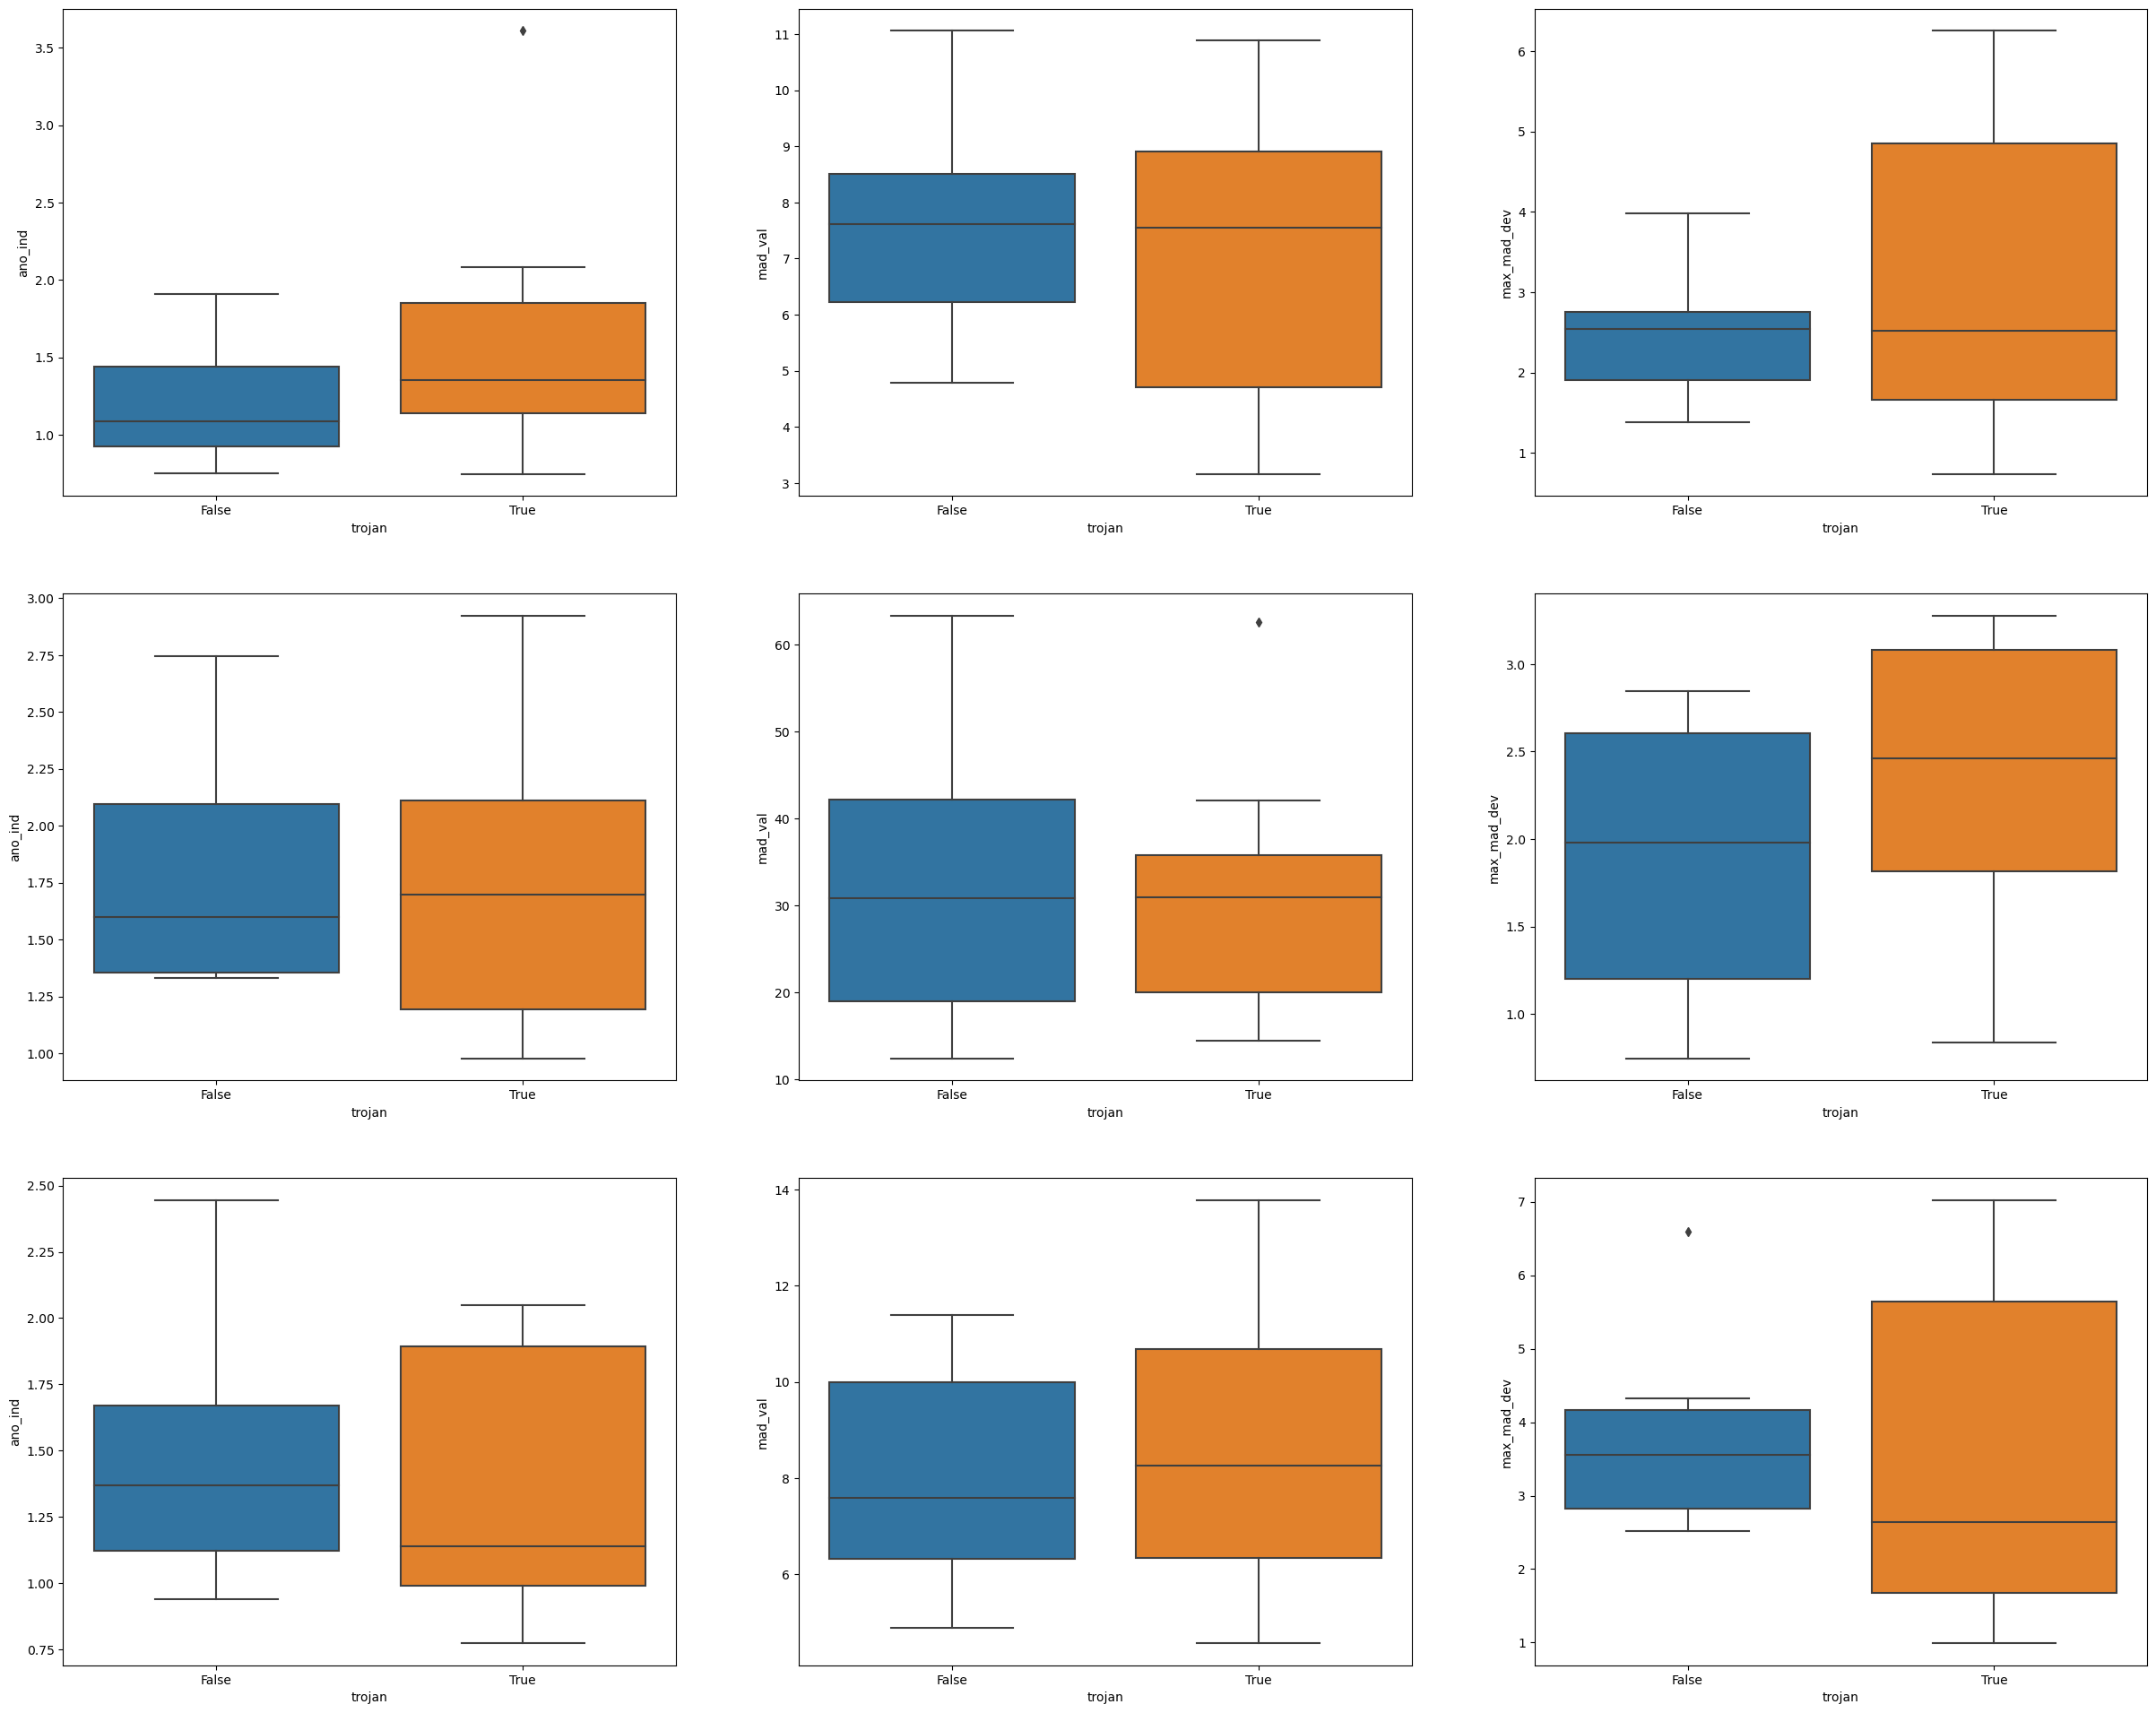

In [61]:
TYPE = ['trigger', 'pattern', 'mask']
y_val = ['ano_ind', 'mad_val', 'max_mad_dev']
rows, cols = len(TYPE), len(y_val)
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10*rows, 8*cols))
for row in range(rows):
    mad_df_by_type = mad_df[mad_df['type'] == TYPE[row]]
    for col in range(cols):
        if rows == 1 and cols == 1:
            ax = axs
        elif rows == 1 or cols == 1:
            ax = axs[row if rows != 1 else col]
        else:
            ax = axs[row, col]
        sns.boxplot(data=mad_df_by_type, x='trojan', y= y_val[col], ax=ax)
plt.show()

In [33]:
model_target_labels = []
for ind in range(375, 401):
    model_spec_filepath = os.path.join(MODEL_FILEDIR, 'trojan', num_to_model_id(ind), 'attack_specification.pt')
    model_target_labels.append(torch.load(model_spec_filepath)['target_label'])

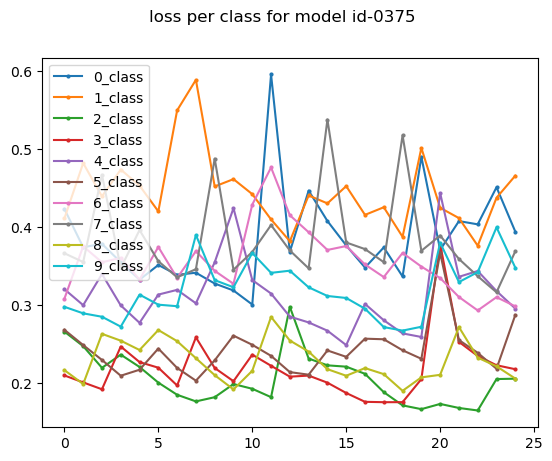

In [69]:
for lbl in range(10):
    plt.plot(SPECS_DICT[suspicious_model_id+'_'+SPECS[0]+'_'+str(lbl)][175:200], '-o', markersize=2, label=f'{lbl}_class')
# plt.plot(LOSS_DICT[8][:500], '-o', markersize=2, label=f'target_class')
# plt.plot(avg_loss, '-o', markersize=2, label=f'avg_of_other_class')
plt.legend()
plt.suptitle('loss per class for model id-0375')
plt.show()

In [ ]:
figs, axs = plt.subplots(ncols=4, nrows=2, figsize=(24, 8))
for row in range(2):
    for col in range(4):
        for lbl in [0, 8]:
            if col == 3:
                m = np.asarray(SPECS_DICT[suspicious_model_id+'_'+SPECS[3*row+1]+'_'+str(lbl)])
                p = np.asarray(SPECS_DICT[suspicious_model_id+'_'+SPECS[3*row+2]+'_'+str(lbl)])
                axs[row, col].plot(m*p, '-o', markersize=2, label=f'{lbl}_class')
                axs[row, col].set_title('trigger')
            else:    
                axs[row, col].plot(SPECS_DICT[suspicious_model_id+'_'+SPECS[3*row+(col+1)]+'_'+str(lbl)], '-o', markersize=2, label=f'{lbl}_class')
                axs[row, col].set_title(suspicious_model_id+'_'+SPECS[3*row+(col+1)])
plt.legend()
plt.show()

In [ ]:
figs, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
LAMBD = 1
for col in range(2):
    for lbl in [0, 8]:
        m = np.asarray(OUTPUT_DICT[OUTPUT[col*3+1]+'_'+str(lbl)][:60])
        # p = np.asarray(OUTPUT_DICT[OUTPUT[col*3+2]+'_'+str(lbl)][:60])
        loss = np.asarray(OUTPUT_DICT[OUTPUT[0]+'_'+str(lbl)][:60])
        axs[col].plot(LAMBD*m+loss, '-o', markersize=2, label=f'{PRED_DICT[lbl]}_class')
        if col == 0:
            norm = 'l1'
        else:
            norm = 'l2'
        axs[col].set_title(f'{norm}_trigger_with_loss_lambd_{LAMBD}')
plt.show()

## Classificaton

In [105]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [140]:
TYPE = ['trigger', 'pattern', 'mask']
y_val = ['mad_val', 'max_mad_dev', 'ano_ind']
X, y = [], []
for num in range(375, 500):
    model_id = num_to_model_id(num)
    mad_df_by_model_id = mad_df[mad_df['model_id'] == model_id]
    for cot in [True, False]:
        X.append(mad_df_by_model_id.loc[mad_df_by_model_id['trojan'] == True, y_val].to_numpy().flatten())
        y.append(cot)
X = np.stack(X, axis=0)

In [115]:
from sklearn.linear_model import LinearRegression

In [143]:
N = 30
clf = GradientBoostingClassifier(learning_rate=.003, n_estimators=500)     # cen - .47149433, acc - .7916 
cen, acc = bootstrap_performance(X, 
                                 y,
                                 clf,
                                 n=N,
                                 test_size=.2)
np.mean(cen), np.mean(acc)

100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


(0.9000047147129487, 0.1448)

## Visualization

In [55]:
import torchvision.transforms as T
import torchvision
transform = T.ToPILImage()

GRID_KEYS = ['masks', 'patterns', 'triggers']
GRID_DICT = {k:[] for k in GRID_KEYS}
for cot in clean_or_trojan:
    small_grid_dict = {k:[] for k in GRID_KEYS}
    for i in range(10):
        m, p = TRIGGER_DICT[cot+'_'+str(i)]
        for k, v in list(zip(GRID_KEYS, [m, p, m*p])):
            img = torch.mean(v, dim=0)
            norm_img = (img - img.min())/(img.max()-img.min())
            small_grid_dict[k].append(norm_img)
    for k, v in small_grid_dict.items():
        grid = torchvision.utils.make_grid(v, nrow=5)
        GRID_DICT[k].append(grid)

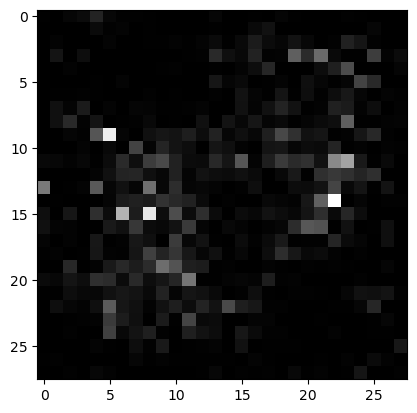

In [63]:
test = np.mean(TRIGGER_DICT[0], axis=0)
norm_test = (test - test.min())/(test.max()-test.min())
plt.imshow(np.transpose(np.concatenate([norm_test]*3, axis=0), (1,2,0)), interpolation='nearest')

In [ ]:
img = GRID_DICT['triggers'][0].numpy()
plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')

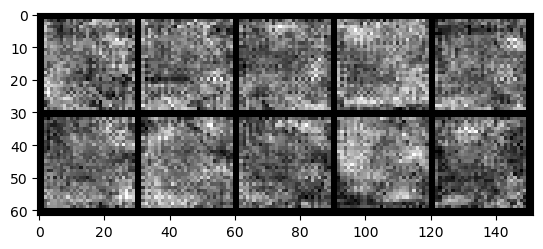

In [59]:
img = GRID_DICT['triggers'][1].numpy()
plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')